# Автокодировщики


![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Autoencoder_schema.png/528px-Autoencoder_schema.png 'Michela Massi')

В данном проекте наша задача — написать и обучить несколько вариантов автокодировщиков, оценить их свойства и применимость для различных задач. Для этого мы будем использовать датасеты лиц [*(LFW)*](https://vis-www.cs.umass.edu/lfw/) и цифр *(MNIST)*. Во всех случаях мы будем применять достаточно простые свёрточные архитектуры и латентные вектора малых размеров, чтобы полученные результаты были более наглядными.

In [ ]:
! pip install pytorch-lightning --quiet

     |████████████████████████████████| 800 kB 359 kB/s 
     |████████████████████████████████| 512 kB 50.9 MB/s 
     |████████████████████████████████| 125 kB 29.4 MB/s 


In [ ]:
import os

import pandas as pd
import numpy as np

from skimage import io, transform
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST 
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import LightningLoggerBase

from tqdm import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize': (15, 9)})

## Загрузка и подготовка данных

Создадим `DataModule` из датасета *LFW*.

In [ ]:
class FacesDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 4):
        super().__init__()
        self.batch_size = batch_size
    
    def prepare_data(self):
        images_name = 'lfw-deepfunneled'
        attrs_name = 'lfw_attributes.txt'
        if not os.path.exists(images_name):
            print('Images not found, downloading...')
            os.system('wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz')
            print('Extracting...')
            os.system('tar xvzf tmp.tgz && rm tmp.tgz')
            print('Done')
        if not os.path.exists(attrs_name):
            print('Attributes not found, downloading...')
            os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
            print('Done')
        
        # reading attributes
        self.df_attrs = pd.read_csv('lfw_attributes.txt', 
                                    sep='\t', skiprows=1)
        self.df_attrs = pd.DataFrame(self.df_attrs.iloc[:,:-1].values, 
                                     columns=self.df_attrs.columns[1:])
        # reading photos
        photo_ids = []
        for dirpath, dirnames, filenames in os.walk(images_name):
            for fname in filenames:
                if fname.endswith(".jpg"):
                    fpath = os.path.join(dirpath,fname)
                    photo_id = fname[:-4].replace('_',' ').split()
                    person_id = ' '.join(photo_id[:-1])
                    photo_number = int(photo_id[-1])
                    photo_ids.append({'person': person_id,
                                      'imagenum': photo_number,
                                      'photo_path': fpath})
        
        photo_ids = pd.DataFrame(photo_ids)

        df = pd.merge(self.df_attrs, photo_ids, on=('person', 'imagenum'))

        self.all_photos = df['photo_path'].apply(io.imread)\
        .apply(lambda img: img[80:-80,80:-80])\
        .apply(lambda img: transform.resize(img, [64, 64]))

        self.all_photos = np.stack(self.all_photos.values)
        self.all_attrs = df.drop(['photo_path', 
                                  'person', 
                                  'imagenum'], axis=1)

    def setup(self, stage: str):    
        self.X_train, self.X_val = train_test_split(self.all_photos, 
                                                    test_size=.2)
        
        self.X_train = np.moveaxis(self.X_train, 3, 1)
        self.X_val = np.moveaxis(self.X_val, 3, 1)

        self.X_train = torch.from_numpy(self.X_train).float()
        self.X_val = torch.from_numpy(self.X_val).float()

    def train_dataloader(self):
        return DataLoader(self.X_train, batch_size=4)

    def val_dataloader(self):
        return DataLoader(self.X_val, batch_size=4)

In [ ]:
faces_data = FacesDataModule()

Хорошо. Теперь посмотрим на лица, с которыми нам придётся работать.

In [ ]:
faces_data.prepare_data()

In [ ]:
faces_data.setup(stage=None)

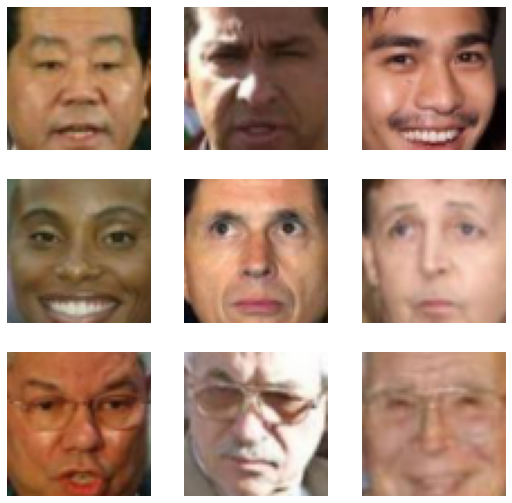

In [ ]:
plt.figure(figsize=(9, 9))
for image_no in range(9):
    face = faces_data.X_train[image_no]
    face = face.numpy()
    face = np.moveaxis(face, 0, 2)
    plt.subplot(3, 3, image_no + 1)
    plt.axis('off')
    plt.imshow(face)
plt.show()

Окей, качество не идеальное, но нам подойдёт.

## Обычный автокодировщик

В этом разделе мы напишем и обучим обычный автоэнкодер.

Архитектура выглядит так:

<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">

Сначала энкодер сжимает изображение в латентный вектор, а затем декодер пытается его восстановить. В качетве функции потерь используется обычная *MSE (mean squared error)*.

Зададим размер латентного вектора равным 64. Он достаточно большой, так что энекодер сможет сохранить достаточно информации об изображении, но слишком мал для того, чтобы сохранить всю фотографию, так что декодеру придётся поучиться.

In [ ]:
dim_code = 64 # выберите размер латентного вектора

Реализуем autoencoder. Будем использовать простую архитектуру из трёх свёрточных слоёв с нормализацией батча и двух линейных слоёв.

In [ ]:
class Autoencoder(pl.LightningModule):
    def __init__(self, dimension: int=64):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

        self.loss = nn.MSELoss()

        self.dimension = dimension

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*64*8, 128),
            nn.ReLU(),
            nn.Linear(128, self.dimension)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.dimension, 128),
            nn.ReLU(),
            nn.Linear(128, 64*64*8),
            nn.ReLU(),
            nn.Unflatten(1, (8, 64, 64)),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(8, 3, kernel_size=3, stride=1, padding=1),
        )
    
    def forward(self, input):
        latent_code = self.encoder(input)
        reconstruction = self.decoder(latent_code)
       
        return reconstruction, latent_code
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters())
        return optimizer
    
    def training_step(self, batch, batch_idx):
        reconstructed, _ = self.forward(batch)
        loss = self.loss(reconstructed, batch)
        self.log('train_loss', loss, prog_bar=False)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        reconstructed, _ = self.forward(batch)
        loss = self.loss(reconstructed, batch)
        self.log('val_loss', loss, prog_bar=False)
        return {'loss': loss}

    def training_epoch_end(self, outputs):
        all_losses = [x['loss'].item() for x in outputs]
        loss = sum(all_losses) / len(all_losses)
        self.train_losses.append(loss)
        metrics = {'train_loss': loss}
        self.log_dict(metrics, prog_bar=True)
    
    def validation_epoch_end(self, outputs):
        all_losses = [x['loss'].item() for x in outputs]
        loss = sum(all_losses) / len(all_losses)
        self.val_losses.append(loss)
        metrics = {'val_loss': loss}
        self.log_dict(metrics, prog_bar=True)

In [ ]:
model = Autoencoder()

In [ ]:
trainer = pl.Trainer(max_epochs=20, accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, faces_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | loss    | MSELoss    | 0     
1 | encoder | Sequential | 4.2 M 
2 | decoder | Sequential | 4.2 M 
---------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.773    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
torch.save(model.state_dict(), 'ae.pt')

In [ ]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize': (15, 9)})

In [ ]:
losses = pd.DataFrame({'train los': model.train_losses,
                       'val los': model.val_losses[1:]})

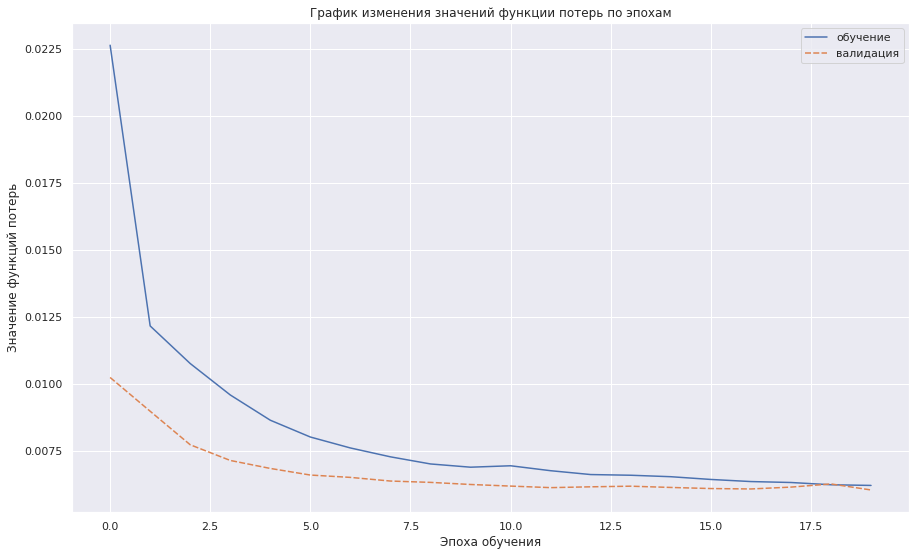

In [ ]:
g = sns.lineplot(data=losses)

g.set(title='График изменения значений функции потерь по эпохам',
      xlabel='Эпоха обучения',
      ylabel='Значение функций потерь')

g.legend(['обучение', 'валидация']);

Давайте посмотрим, как наш автоэнкодер кодирует и восстанавливает картинки из валидационной выборки:

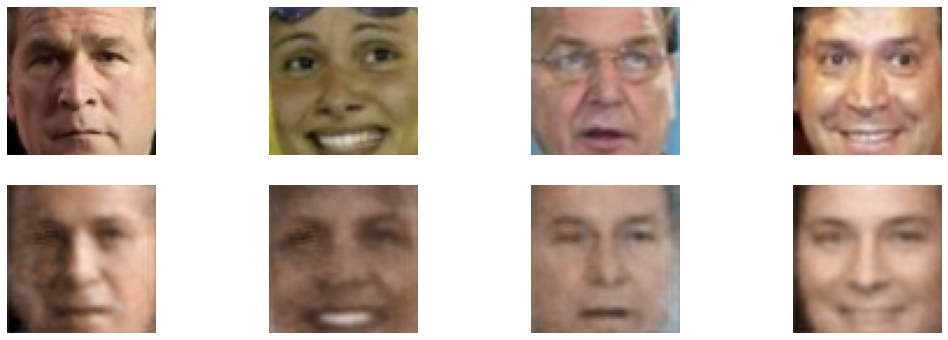

In [ ]:
model.eval()
with torch.no_grad():
    X_batch = next(iter(faces_data.val_dataloader()))
    X_batch = X_batch
    reconstructed, _ = model(X_batch)
    X_batch = X_batch.numpy()
    reconstructed = reconstructed.cpu().numpy()
    X_batch = np.moveaxis(X_batch, 1, 3)
    reconstructed = np.moveaxis(reconstructed, 1, 3)

    plt.figure(figsize=(18, 6))
    for image_no in range(4):
        plt.subplot(2, 4, image_no + 1)
        plt.axis('off')
        plt.imshow(X_batch[image_no])
        
        plt.subplot(2, 4, image_no + 5)
        plt.axis('off')
        plt.imshow(reconstructed[image_no])
    plt.show

Неплохо, хотя изображения размытые и некоторые детали (например, очки) теряются. На самом деле, мы такого эффекта и добивались: наш маленький латентный вектор не позволяет сохранить всё изображение, но позволяет закодировать самые важные элементы. Если держать в уме, что изображения были сжаты в 64 раза, а потом разжаты, то результат очень даже впечатляющий.

### Генерация новых лиц

Попробуем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а создадим *новое* лицо.

Для этого посмотрим, как для валидационной выборки были распределены значения латентного вектора, сгенерируем случайные вектора из того же распределения и передадим их декодеру. 

Найдём средние и стандартные отклонения для валидационной выборки.

In [ ]:
latents = []
with torch.no_grad():
    for X_batch in faces_data.val_dataloader():
        X_batch = X_batch.float()
        _, latent = model(X_batch)
        latent = latent.cpu().numpy()

        for i in range(latent.shape[0]):
            latents.append(latent[i])

In [ ]:
latents = pd.DataFrame(latents)

In [ ]:
means = latents.mean()
stds = latents.std()

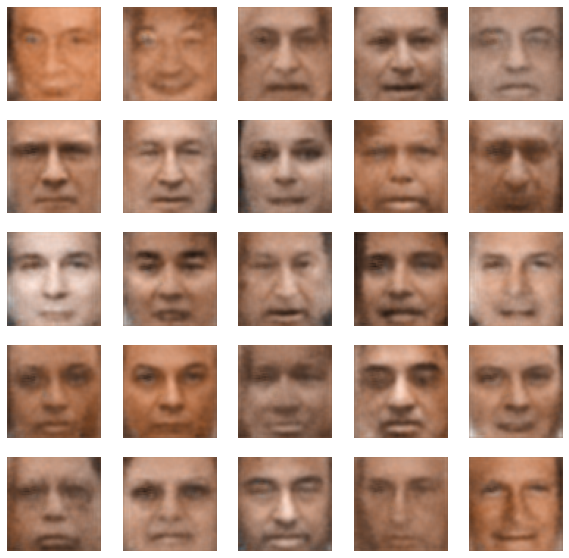

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
with torch.no_grad():
    z = np.random.randn(25, dim_code)
    z = stds.values * z + means.values
    z = torch.tensor(z)
    z = z.float()
    output = model.decoder(z)
    output = output.cpu().numpy()
    output = np.moveaxis(output, 1, 3)
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.axis("off")
        plt.imshow(output[i])
    plt.show()

Замечательно. Некоторые лица выглядят жутковато, все изображения получились размытыми, но это определённо лица!

### Добавление улыбок

Давайте научимся добавлять людям улыбки =)

План такой:

1. Нужно выделить "вектор улыбки": для этого из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

2. Вычислить латентный вектор для всех улыбающихся людей и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. Подарить улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. В идеале мы получим того же человека, но уже с улыбкой!

In [ ]:
smiling_index = faces_data.all_attrs.sort_values(by='Smiling').tail(40).index
sad_index = faces_data.all_attrs.sort_values(by='Smiling').head(40).index

In [ ]:
smiling = faces_data.all_photos[smiling_index]
sad = faces_data.all_photos[sad_index]

In [ ]:
smiling = np.moveaxis(smiling, 3, 1)
sad = np.moveaxis(sad, 3, 1)

In [ ]:
smiling = torch.from_numpy(smiling).float()
sad = torch.from_numpy(sad).float()

In [ ]:
smiling_loader = torch.utils.data.DataLoader(smiling, batch_size=4)
sad_loader = torch.utils.data.DataLoader(sad, batch_size=4)

In [ ]:
smiling_latents = []
with torch.no_grad():
    for X_batch in smiling_loader:
        _, latent = model(X_batch)
        latent = latent.cpu().numpy()

        for i in range(latent.shape[0]):
            smiling_latents.append(latent[i])

In [ ]:
sad_latents = []
with torch.no_grad():
    for X_batch in sad_loader:
        _, latent = model(X_batch)
        latent = latent.cpu().numpy()

        for i in range(latent.shape[0]):
            sad_latents.append(latent[i])

In [ ]:
smiling_latents = pd.DataFrame(smiling_latents)
sad_latents = pd.DataFrame(sad_latents)

In [ ]:
smile = smiling_latents.mean() - sad_latents.mean()

In [ ]:
smile = torch.from_numpy(smile.values)

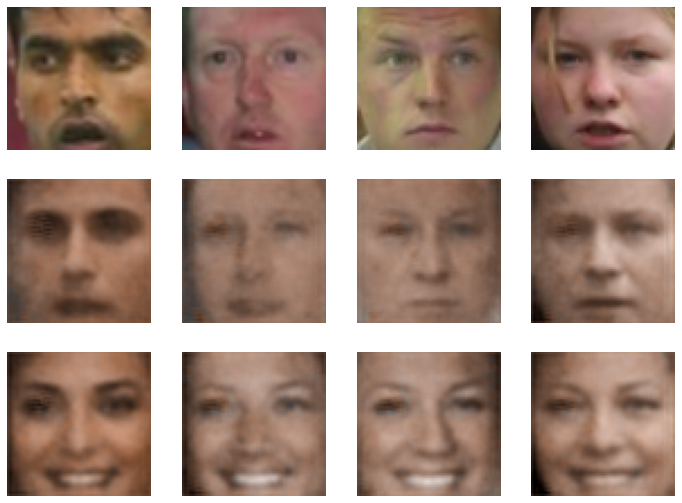

In [ ]:
with torch.no_grad():
    X_batch = next(iter(sad_loader))
    latent = model.encoder(X_batch)
    reconstructed = model.decoder(latent)
    latent += smile
    reconstructed_smile = model.decoder(latent)
    X_batch = X_batch.numpy()
    reconstructed = reconstructed.cpu().numpy()
    reconstructed_smile = reconstructed_smile.cpu().numpy()
    X_batch = np.moveaxis(X_batch, 1, 3)
    reconstructed = np.moveaxis(reconstructed, 1, 3)
    reconstructed_smile = np.moveaxis(reconstructed_smile, 1, 3)

    plt.figure(figsize=(12, 9))
    for image_no in range(4):
        plt.subplot(3, 4, image_no + 1)
        plt.axis("off")
        plt.imshow(X_batch[image_no])
        
        plt.subplot(3, 4, image_no + 5)
        plt.axis("off")
        plt.imshow(reconstructed[image_no])

        plt.subplot(3, 4, image_no + 9)
        plt.axis("off")
        plt.imshow(reconstructed_smile[image_no])
    plt.show

В верхнем ряду расположены оригинальные фотографии, в среднем -- их представление после обработки автоэнкодером, с нижнем -- с дорисованными улыбками.

Похоже, что среди фотографий улыбающихся людей, которые мы отобрали, было много фотографий женщин и наша сеть решила, что женское лицо это тоже часть вектора "улыбка". Неожиданный эффект.

## Вариационный автокодировщик

Теперь займёмся обучением вариационного автоэнкодера — проапгрейженной версии обычного. Обучать будем на датасете *MNIST*, содержащем написанные от руки цифры от 0 до 9.

Приготовим *DataModule*.

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = './mnist_data/', batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def setup(self, stage: str):
        self.train_dataset = MNIST(self.data_dir, train=True, 
                                   transform=transforms.ToTensor(), 
                                   download=True)
        self.val_dataset = MNIST(self.data_dir, 
                                 transform=transforms.ToTensor(), 
                                 train=False)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

In [ ]:
mnist_data = MNISTDataModule()

И реализуем саму архитектуру. Будем использовать по два свёрточных слоя с нормализацией батча и один линейный слой.

У VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
class VAE(pl.LightningModule):
    def __init__(self, features: int=16):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

        self.loss = self.loss_vae

        self.features = features

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=28*28*16, out_features=self.features*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.features, out_features=16*28*28),
            nn.ReLU(),
            nn.Unflatten(1, (16, 28, 28)),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=28*28, out_features=28*28)
        )

    def encode(self, x):
        x = self.encoder(x).view(-1, 2, self.features)

        mu = x[:, 0, :] 
        logsigma = x[:, 1, :] 

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std) 
            return sample
        else:
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)

        return reconstruction
    
    def forward(self, input):
        mu, logsigma = self.encode(input)

        z = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

    def KL_divergence(self, mu, logsigma):
        """
        часть функции потерь, которая отвечает за "близость" 
        латентных представлений
        """
        loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
        return loss

    def log_likelihood(self, x, reconstruction):
        """
        часть функции потерь, которая отвечает за качество 
        реконструкции (как mse в обычном autoencoder)
        """
        loss = nn.BCELoss(reduction='sum')
        return loss(reconstruction, x)

    def loss_vae(self, x, mu, logsigma, reconstruction):
        return self.KL_divergence(mu, logsigma) + self.log_likelihood(x, reconstruction)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters())
        return optimizer
    
    def training_step(self, batch, batch_idx):
        mu, logsigma, reconstruction = self.forward(batch[0])
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = self.loss(batch[0], mu, logsigma, reconstruction)
        self.log('train_loss', loss, prog_bar=False)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        mu, logsigma, reconstruction = self.forward(batch[0])
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = self.loss(batch[0], mu, logsigma, reconstruction)
        self.log('val_loss', loss, prog_bar=False)
        return {'loss': loss}

    def training_epoch_end(self, outputs):
        all_losses = [x['loss'].item() for x in outputs]
        loss = sum(all_losses) / len(all_losses)
        self.train_losses.append(loss)
        metrics = {'train_loss': loss}
        self.log_dict(metrics, prog_bar=True)
    
    def validation_epoch_end(self, outputs):
        all_losses = [x['loss'].item() for x in outputs]
        loss = sum(all_losses) / len(all_losses)
        self.val_losses.append(loss)
        metrics = {'val_loss': loss}
        self.log_dict(metrics, prog_bar=True)

In [ ]:
model = VAE()

In [ ]:
trainer = pl.Trainer(max_epochs=40, accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, mnist_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | encoder | Sequential | 402 K 
2 | decoder | Sequential | 829 K 
---------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.931     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
torch.save(model.state_dict(), 'vae.pt')

Модель обучена, посмотрим на графики значений функции потерь.

In [ ]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize': (15, 9)})

In [ ]:
losses = pd.DataFrame({'train los': model.train_losses,
                       'val los': model.val_losses[1:]})

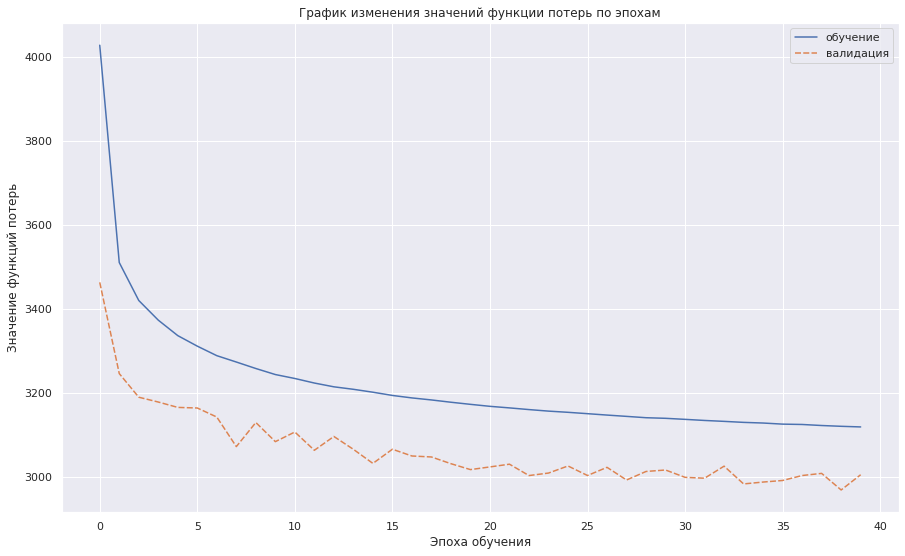

In [ ]:
g = sns.lineplot(data=losses)

g.set(title='График изменения значений функций потерь по эпохам',
      xlabel='Эпоха обучения',
      ylabel='Значение функций потерь')

g.legend(['обучение', 'валидация']);

Значения фукнции потерь ожидаемо падают, наш вариационный автоэнкодер обучается. Давайте посмотрим, как он будет кодировать и восстанавливать картинки с цифрами.

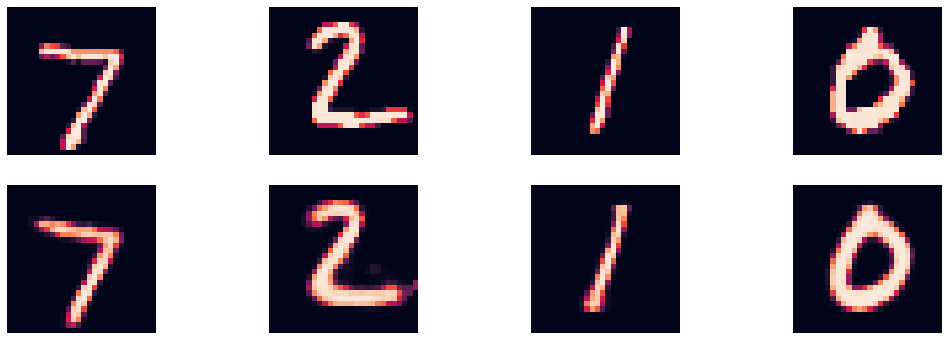

In [ ]:
with torch.no_grad():
    X_batch, _ = next(iter(mnist_data.val_dataloader()))
    mu, logsigma, reconstruction = model(X_batch)
    reconstruction = reconstruction.view(-1, 1, 28, 28)
    X_batch = X_batch.numpy()
    reconstruction = reconstruction.cpu().numpy()

    plt.figure(figsize=(18, 6))
    for image_no in range(4):
        plt.subplot(2, 4, image_no + 1)
        plt.axis("off")
        plt.imshow(X_batch[image_no][0])
        
        plt.subplot(2, 4, image_no + 5)
        plt.axis("off")
        plt.imshow(reconstruction[image_no][0])
    plt.show

Результат очень хорош, видно небольшое размытие (например, на цифре 2), но в целом сеть работает очень хорошо. 

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть декодеру из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

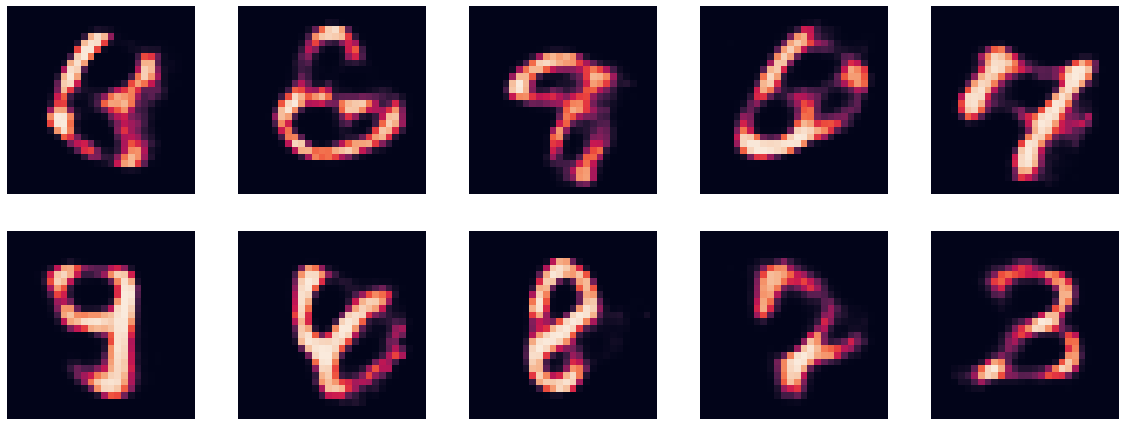

In [ ]:
with torch.no_grad():
    z = np.array([np.random.normal(0, 1, model.features) for i in range(10)])
    z = torch.tensor(z).float()
    output = model.decode(z)
    output = output.view(-1, 1, 28, 28)
    output = output.cpu().numpy()

    plt.figure(figsize=(20, 20))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.axis("off")
        plt.imshow(output[i][0])
    plt.show()

Часть картинок похожи на цифры (хотя и очень неаккуратно написанные), а некоторые (например, девять, восемь, семь) выглядят очень даже хорошо. И этого удалось достичь с очень простой архитектурой автоэнкодера (всего по два свёрточных слоя на энкодер и декодер).

### Визуализация летентных векторов

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Наша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр. 

Для отображения векторов в двумерном пространстве воспользуемся алгоримом t-distributed stochastic neighbor embedding. Будем отображать точки, относящиеся к разным цифрам разными цветами, чтобы результат был более наглядным.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
latents = []
labels = []
with torch.no_grad():
    for X_batch, y_batch in mnist_data.val_dataloader():
        mu, logsigma = model.encode(X_batch)
        latent = model.gaussian_sampler(mu, logsigma)
        for i in range(X_batch.shape[0]):
            latents.append(latent[i].cpu().numpy())
            labels.append(y_batch[i].cpu().numpy())

In [ ]:
latents_two_dim = pd.DataFrame(TSNE(init='pca').fit_transform(latents))

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [ ]:
latents_two_dim['labels'] = labels

In [ ]:
latents_two_dim.labels = latents_two_dim.labels.astype(int)

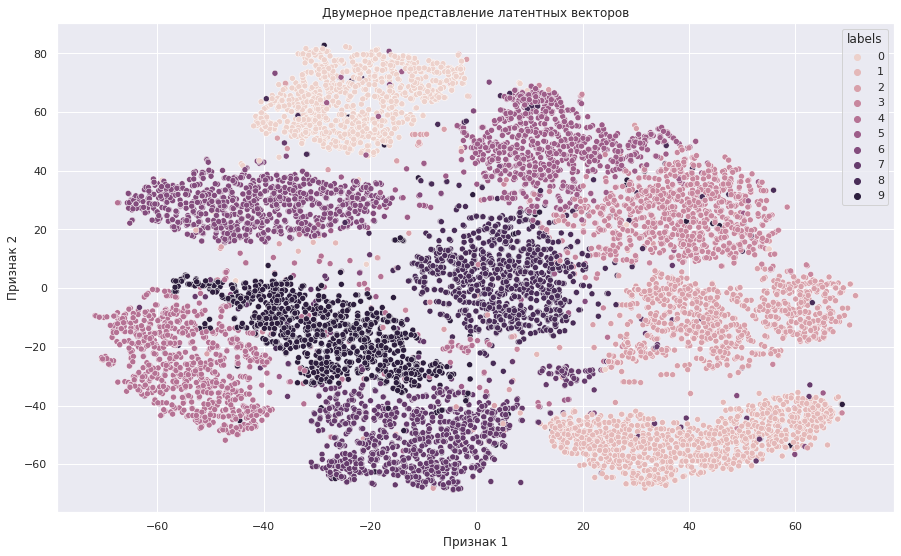

In [ ]:
g = sns.scatterplot(data=latents_two_dim, x=0, y=1, hue='labels', legend='full')
g.set(title='Двумерное представление латентных векторов',
      xlabel='Признак 1',
      ylabel='Признак 2');

Видно, что в двумерном представлении латентные вектора вариационного автоэнекодера довольно хорошо визуально разделимы.

## Условный вариационный автоэнкодер


Итак, мы уже обучили вариационный автоэнекодер на датасете фотографий и получили новые картинки, используя генерацию шума и декодер. 

Теперь предположим, что нам нужно создавать не изображения случайных цифр, а, например, изображения цифры 8. Добавим к нашей нейросети функцию генерации цифр "по заказу".

### Архитектура

На картинке ниже представлена архитектура простого условного вариационного автоэнекодера.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



Таким образом, при генерации новой случайной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

In [ ]:
class CVAE(pl.LightningModule):
    def __init__(self, features: int=16):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

        self.loss = self.loss_vae

        self.features = features
        self.label = nn.Embedding(10, features)

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=28*28*16, out_features=self.features*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.features*2, out_features=16*28*28),
            nn.ReLU(),
            nn.Unflatten(1, (16, 28, 28)),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=28*28, out_features=28*28)
        )

    def encode(self, x, class_num):
        class_num = self.label(class_num)
        x = self.encoder(x).view(-1, 2, self.features)

        mu = x[:, 0, :] 
        logsigma = x[:, 1, :] 

        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std) 
            return sample
        else:
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        class_num = self.label(class_num)
        z = torch.cat((z, class_num), dim = 1)
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)

        return reconstruction
    
    def forward(self, input, class_num):
        mu, logsigma, _ = self.encode(input, class_num)

        z = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

    def KL_divergence(self, mu, logsigma):
        """
        часть функции потерь, которая отвечает за "близость" 
        латентных представлений
        """
        loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
        return loss

    def log_likelihood(self, x, reconstruction):
        """
        часть функции потерь, которая отвечает за качество 
        реконструкции (как mse в обычном autoencoder)
        """
        loss = nn.BCELoss(reduction='sum')
        return loss(reconstruction, x)

    def loss_vae(self, x, mu, logsigma, reconstruction):
        return self.KL_divergence(mu, logsigma) + self.log_likelihood(x, reconstruction)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters())
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        mu, logsigma, reconstruction = self.forward(X_batch,
                                                    y_batch)
        
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        loss = self.loss(X_batch, mu, logsigma, reconstruction)
        self.log('train_loss', loss, prog_bar=False)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        X_batch, y_batch = batch

        mu, logsigma, reconstruction = self.forward(X_batch,
                                                    y_batch)
        
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        loss = self.loss(X_batch, mu, logsigma, reconstruction)

        self.log('val_loss', loss, prog_bar=False)
        return {'loss': loss}

    def training_epoch_end(self, outputs):
        all_losses = [x['loss'].item() for x in outputs]
        loss = sum(all_losses) / len(all_losses)
        self.train_losses.append(loss)
        metrics = {'train_loss': loss}
        self.log_dict(metrics, prog_bar=True)
    
    def validation_epoch_end(self, outputs):
        all_losses = [x['loss'].item() for x in outputs]
        loss = sum(all_losses) / len(all_losses)
        self.val_losses.append(loss)
        metrics = {'val_loss': loss}
        self.log_dict(metrics, prog_bar=True)

In [ ]:
model = CVAE()

Модель готова, можно приступать к обучению.

In [ ]:
trainer = pl.Trainer(max_epochs=40, accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, mnist_data)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | label   | Embedding  | 160   
1 | flatten | Flatten    | 0     
2 | encoder | Sequential | 402 K 
3 | decoder | Sequential | 1.0 M 
---------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.734     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
torch.save(model.state_dict(), 'cvae.pt')

In [ ]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize': (15, 9)})

In [ ]:
losses = pd.DataFrame({'train los': model.train_losses,
                       'val los': model.val_losses[1:]})

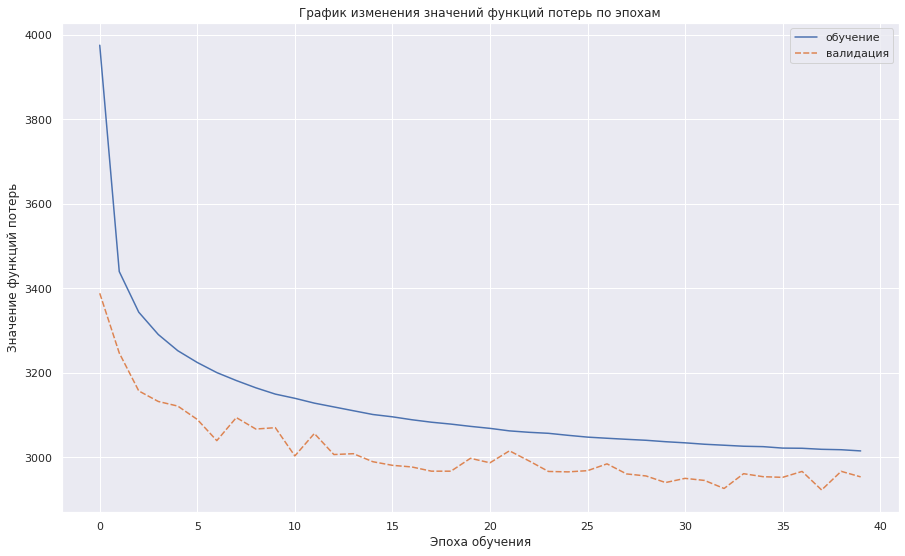

In [ ]:
g = sns.lineplot(data=losses)

g.set(title='График изменения значений функций потерь по эпохам',
      xlabel='Эпоха обучения',
      ylabel='Значение функций потерь')

g.legend(['обучение', 'валидация']);

### Генерация цифр


А теперь попробуем сэмплировать из CVAE. Это гораздо интереснее, чем для простого автоэнкодера, так как мы можем взять один и тот же латентный вектор, но "восстановить" из него картинки разных классов. Попробуем сгенерировать цифры 5 и 7.

In [ ]:
z = np.array([np.random.normal(0, 1, model.features) for i in range(10)])
label_five = np.array([5] * 10)
label_seven = np.array([7] * 10)

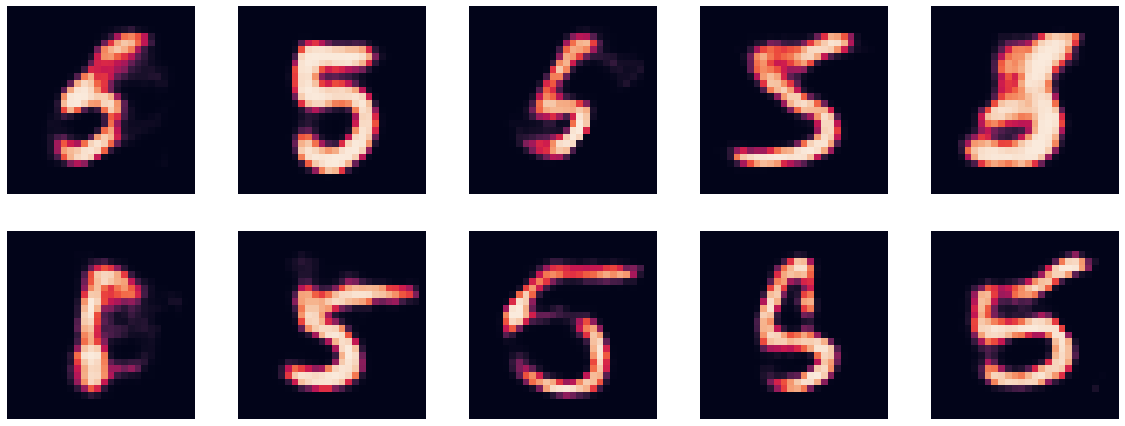

In [ ]:
with torch.no_grad():
    z = torch.tensor(z).float()
    label_five = torch.tensor(label_five).int()
    output = model.decode(z, label_five)
    output = output.view(-1, 1, 28, 28)
    output = output.cpu().numpy()
    
    plt.figure(figsize=(20, 20))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.axis("off")
        plt.imshow(output[i][0])
    plt.show()

<ipython-input-19-30f3b4f00199>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z).float()


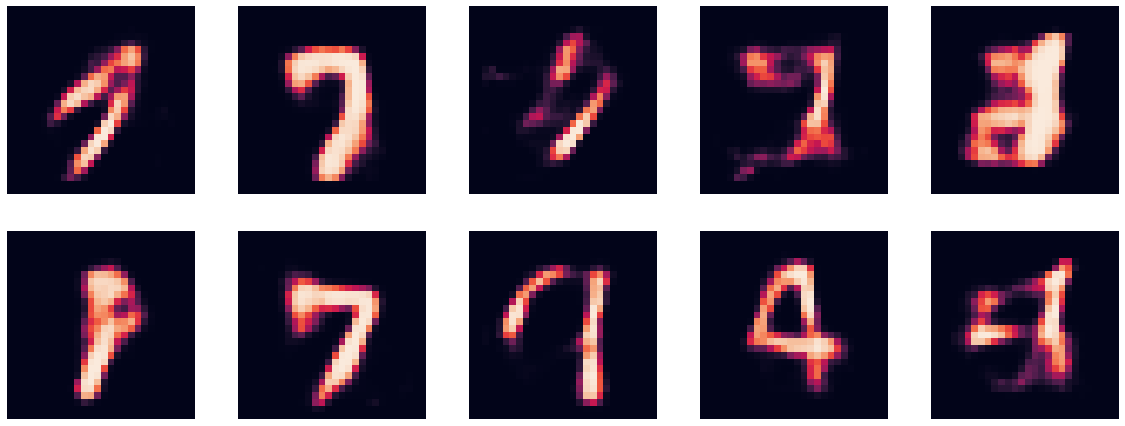

In [ ]:
with torch.no_grad():
    z = torch.tensor(z).float()
    label_seven = torch.tensor(label_seven).int()
    output = model.decode(z, label_seven)
    output = output.view(-1, 1, 28, 28)
    output = output.cpu().numpy()
    
    plt.figure(figsize=(20, 20))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.axis("off")
        plt.imshow(output[i][0])
    plt.show()

Здорово! У нас получилось создать несколько достоверно выглядящих пятёрок и семёрок. Пятёрки вышли особенно хорошо, а вот некоторые семёрки подзрительно похожи на четвёрки. При этом мы использовали очень простую сеть и обучали её всего 40 эпох. Да, цифры - не самые сложные объекты для генерации и нам всё ещё требуется визуальный контроль человека, но результат очень впечатляет.

### Визуализация латентных векторов

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
latents = []
labels = []
with torch.no_grad():
    for X_batch, y_batch in mnist_data.val_dataloader():
        mu, logsigma, _ = model.encode(X_batch, y_batch)
        latent = model.gaussian_sampler(mu, logsigma)
        for i in range(X_batch.shape[0]):
            latents.append(latent[i].cpu().numpy())
            labels.append(y_batch[i].cpu().numpy())

In [ ]:
latents_two_dim = pd.DataFrame(TSNE(init='pca').fit_transform(latents))

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [ ]:
latents_two_dim['labels'] = labels

In [ ]:
latents_two_dim.labels = latents_two_dim.labels.astype(int)

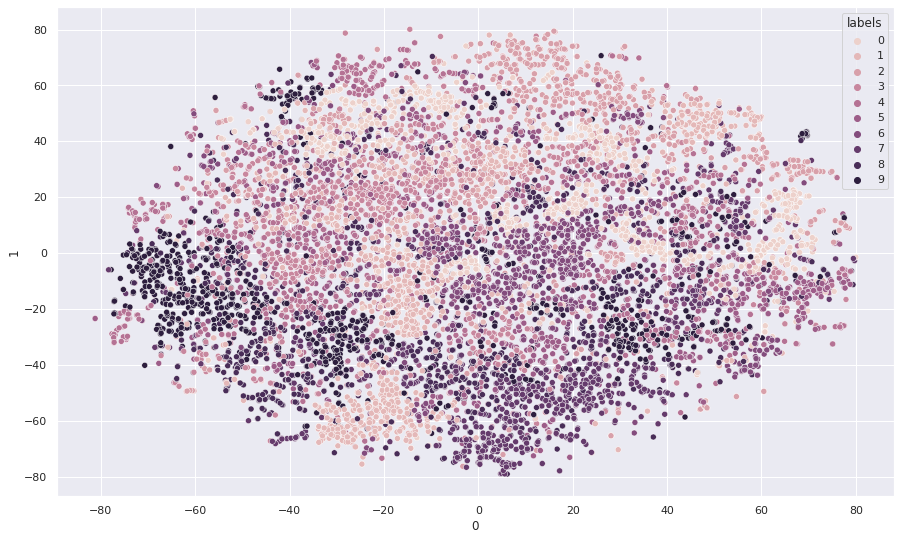

In [ ]:
sns.scatterplot(data=latents_two_dim, x=0, y=1, hue='labels', legend='full')
g.set(title='Двумерное представление латентных векторов',
      xlabel='Признак 1',
      ylabel='Признак 2');

В данном случае мы уже не можем чётко отделить кластеры отдельных цифр.

## Вывод

В данном проекте мы создали и обучили три автокодировщика с различными архитектурами:

* обычный автокодировщик
* вариационный автокодировщик
* условный вариационный автокодировщик

Для обучения мы использовали датасеты лиц *(LFW)* и цифр *(MNIST)*.

Одной из целей данной работы было проведение экспериментов с автокодировщиками и оценка их применимости для различных задач.

Для начала мы обучили обычный автокодировщик (простую архитектуру с тремя свёрточными и двумя линейными слоями) на датасете лиц. Мы сознательно выбрали небольшой размер латентного вектора, чтобы энкодер не мог сохранять картинки целиком, а был вынужден кодировать самые важные элементы изображения.

Сначала мы проверили результаты работы обычного автокодировщика на сжатии и восстановлении фотографий. Полученные из декодера картинки сохраняли значительную часть элементов оригинала, хотя изображения полуались несколько размытыми.

Затем мы сгенерировали несколько случайных лиц. Для этого мы посмотрели на распределения латентных векторов изображений из валидационной выборки и засемплировали несколько случайных выборок из этих распределений. Полученные изображения действительно были похожи на фотографии живых людей, хотя и довольно размытые.

Также мы провели следующий эксперимент: отобрали несколько фотографий улыбающихся людей и несколько фотографий грустных людей. Закодировали их в латентные вектора и посчитали разницу. Полученный "вектор улыбки" мы добавили к латентным векторам грустных людей и пропустили через декодер. В результате мы получили фотографии улыбающихся людей. При этом возник интересный нюанс: в следствие особенностей выборки наша сеть решила, что в "вектор улыбки" входят и женские черты лица, поэтому они также перенеслись на декодированные фотографии.

Затем мы обучили вариационный автоэнкодер. Особенностью данной архитектуры является то, что кодировщик учится отображать поступающие данные в пространство с заданными свойствами, так что при генерации новых изображений не приходится оценивать свойства распределения элементов латентных векторов.

Для обучения вариационного автоэнкодера мы использовали датасет цифр MNIST. Нейросети было явно проще кодировать цифры, потому что получаемые из декодера изображения практически не отличались от подаваемых в энкодер. 

Мы также сгенерировали несколько изображений цифр из случайных данных, полученных из нормального распределения. Часть полученных картинок были похожи на цифры (хотя и очень неаккуратно написанные), а некоторые (например, цифры девять, восемь, семь) выглядели очень даже хорошо. И этого удалось достичь с очень простой архитектурой вариационного автоэнкодера (всего по два свёрточных слоя на энкодер и декодер).

Мы также визуализировали латентные вектора вариационного автоэнкодера в двумерном пространстве. На полученном графике видно, что вектора различных цифр очень хорошо кластеризуются и визуально отделимы друг от друга.

Наконец, мы построили и обучили на датасете цифр условный вариационный автоэнкодер. Особенностью данной архитектуры является возможность генерации изображений определённых класов "на заказ". Для демонстрации этой возможности мы сгенерировали из нормального распределения латентные вектора и получили из каждого изображения цифр пять и семь. У нас действительно получились изображения именно заданных классов.

Полученные результаты экспериментов наглядно демонстрируют возможности различных архитектур автокодировщиков. Кроме того, автокодировщики часто применяются для уменьшения шума в данных или обнаружения аномальных значений.